# Short-Time Fourier Transform (STFT)

A ideia da Short-Time Fourier Transform (STFT) é realizar a Transformada de Fourier em cada pequena seção de um sinal, utilizando uma janela deslizante. A STFT é uma ferramenta para extrair informações sobre o conteúdo espectral localizado no tempo.

A STFT de uma sequência é definida na forma:
\begin{equation}
    STFT\{x[n]\} = X(m,\omega) = \sum_{n=-\infty}^{\infty} x[n]g[n-mR]e^{-j\omega n}
\end{equation}
onde $R$ é o tamanho do deslocamento da janela, em amostras, $m$ é índice de contagem do deslocamento/posição no tempo e $g[n]$ a função janela utilizada.

Veja a ilustração do processo a seguir:
<img src="./figures/stft_process.jpg" />
Figura 1. Ilustração do processo da STFT. Fonte: <a href="https://doi.org/10.1016/B978-0-12-374490-6.00007-6">Digital Signal Processing System Design - Chapter 7</a>

Na prática, lidamos com sequências de comprimento finito e calculamos os coeficientes da DFT de N pontos de cada segmento selecionado pela janela $g[n]$:
\begin{equation}
    X^{N}(m,\omega_{k}) = \sum_{n=0}^{N-1} x[n]g[n-mR]e^{-j\omega_{k}n}\quad \text{para } k=0,\ldots,N-1
\end{equation}
onde $\omega_{k}=2\pi k/N$.

Para tornar mais prática a implementação, é costume deslizar a sequência x[n] e manter a função janela $g[n]$ fixa. Para isto, adiciona-se $mR$ amostras a $n$, de forma que temos
\begin{eqnarray}
    X^{N}(m,\omega_{k}) & = & \sum_{n=0}^{N-1} x[n+mR]g[n]e^{-j\omega_{k}(n+mR)}\\
     & = & e^{-j\omega_{k}mR}\sum_{n=0}^{N-1} x[n+mR]g[n]e^{-j\omega_{k}n}
\end{eqnarray}

O processo é o seguinte:
- 1. Divida o sinal em M seções. Cada seção tem tamanho L, o tamanho da janela $g[n]$ escolhida, e pode ou não se sobrepor à próxima seção:
<img src="./figures/STFT_overlap.png" />
Figura 2. Ilustração do Seccionamento. Fonte: <a href="https://www.originlab.com/doc/Origin-Help/STFT-Algorithm">Origin Help - STFT Algorithm</a>

- 2. Multiplique a janela $g[n]$ pelo segmento atual $x[n+mR]$;
- 3. Zeros serão adicionados (zero padding) nos dois lados da sequência $x[n+mR]g[n]$ se o comprimento L da janela for menor que o número N de pontos de frequência da FFT, $\{\omega_{k}\}_{k=0}^{N-1}$.
- 4. Compute a FFT desta $m$-ésima seção.
- 5. Mova a janela (ou o sinal) de acordo com o tamanho da sobreposição (denominado *hop*) $R$, e repita os passos 1 a 4 até o final da sequência.

Para mais detlhes de implementação veja o livro online [Spectral Audio Signal Processing](https://www.dsprelated.com/freebooks/sasp/Short_Time_Fourier_Transform.html).

O resultado da STFT é uma matriz de N linhas e M colunas, que tomando o quadrado da magnitude gera o chamado **Espectrograma**, o qual representa a *Densidade Espectral de Energia/Potência* (PSD) de um sinal.

As funções janela mais comuns são as seguintes:
- Retangular:
\begin{equation}
    w[n] = \left\{\begin{array}{ccl} 1 & , & \text{se } 0\leq n \leq N-1\\
    0 & , & \text{caso contrário}\end{array}\right.
\end{equation}
- Welch:
\begin{equation}
    w[n] = 1 - \left[ \frac{n-0.5(N-1)}{0.5(N-1)}\right]^{2}
\end{equation}
- Triangular:
\begin{equation}
    w[n] = \frac{2}{N}\left[\frac{N}{2}-\left|n-\frac{N}{2}\right|\right]
\end{equation}
- Bartlett
\begin{equation}
    w[n] = \frac{2}{N-1}\left[\frac{N-1}{2}-\left|n-\frac{N-1}{2}\right|\right]
\end{equation}
- Hanning (Hann)
\begin{equation}
    w[n] = \frac{1}{2}\left[1-\cos\left(\frac{2\pi n}{N-1}\right)\right]
\end{equation}
- Hamming
\begin{equation}
    w[n] = 0.54-0.46 \cos\left(\frac{2\pi n}{N-1}\right)
\end{equation}
- Blackman
\begin{equation}
    w[n] = 0.42-0.5 \cos\left(\frac{2\pi n}{N-1}\right)+0.08\cos\left(\frac{4\pi n}{N-1}\right)
\end{equation}

Quanto mais suave for a borda da janela, menor o vasamento espectral do segmento de amostras no qual ela é aplicada.

Para mais detalhes sobre as funções janela, veja [Wikipedia - Window Function](https://en.wikipedia.org/wiki/Window_function).

Para testar o funcionamento da STFT na análise de sinais, vamos tomar 4 exemplos:
- 1. Uma senóide modulada lentamente em frequência com ruído de fundo: primeiro contato com o Espectrograma;
- 2. Duas senóides de frequência próxima moduladas lentamente, e igualmente, com ruído de fundo: ajustes da STFT e resolução em tempo e frequência;
- 3. Idem ao anterior, mas com descontinuidade na frequência no meio do intervalo;
- 4. Áudio: visualização de um Espectrograma com mais informação.

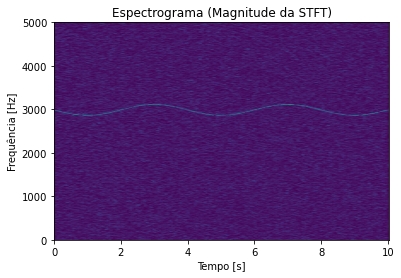

Text(0.5, 1.0, 'Periodograma (Espectro de Amplitude)')

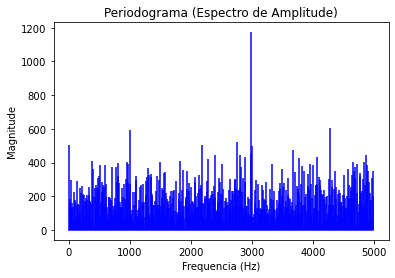

In [5]:
# Exemplo 1: uma senóide em 3 kHz lentamente modulada em frequência com
# ruído de fundo.
# Veja exemplo original em: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
import numpy as np
from scipy import signal
#from scipy.fft import fft
#from scipy.fftpack import fft
from numpy.fft import fft
import matplotlib.pyplot as plt

fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 50
n = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*n)
carrier = amp * np.sin(2*np.pi*3e3*n + mod)
noise = np.random.normal(scale=np.sqrt(noise_power),
                         size=n.shape)
x = carrier + noise

# Ajuste e cômputo da STFT
nperseg = 1024
noverlap = nperseg//2 # divisao inteira
nfft = nperseg
f, t, Zxx = signal.stft(x, fs, nperseg=nperseg,
                        noverlap=noverlap, nfft=nfft)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('Espectrograma (Magnitude da STFT)')
plt.ylabel('Frequência [Hz]')
plt.xlabel('Tempo [s]')
plt.show()

# o que a FFT de todo o sinal resultaria
X = fft(x,nfft)         # calculo da DFT direta pela FFT
f = np.arange(0,nfft)*(fs/nfft)     # frequencias calculadas

plt.figure()
plt.stem(f[0:nfft//2],np.abs(X[0:nfft//2]),'b', \
         markerfmt=" ", basefmt="-b")
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Magnitude')
plt.title('Periodograma (Espectro de Amplitude)')

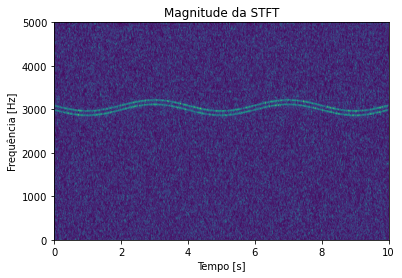

In [6]:
# Exemplo 2: duas senóides, f1= 3 KHz e f2=3.1KHz lentamente moduladas, igualmente, em frequência com
# ruído de fundo.
# Veja exemplo original em: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

fs = 10e3
f1,f2 = 3e3,3.1e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 50
n = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*n)
carrier = amp * np.sin(2*np.pi*f1*n + mod)
carrier += amp * np.sin(2*np.pi*f2*n + mod)
noise = np.random.normal(scale=np.sqrt(noise_power),
                         size=n.shape)
x = carrier + noise

# Ajuste e cômputo da STFT
nperseg = 256
noverlap = nperseg//2 # divisao inteira
nfft = 2*nperseg
f, t, Zxx = signal.stft(x, fs, nperseg=nperseg,
                        noverlap=noverlap, nfft=nfft)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp, shading='gouraud')
plt.title('Magnitude da STFT')
plt.ylabel('Frequência [Hz]')
plt.xlabel('Tempo [s]')
plt.show()

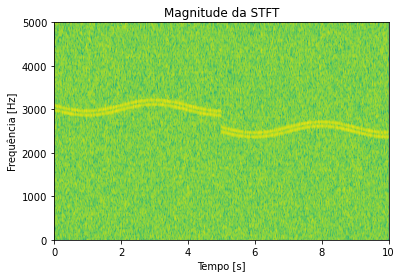

In [3]:
# Exemplo 3: duas senóides, f1= 3 KHz e f2=3.1KHz lentamente moduladas, igualmente, em frequência com
# ruído de fundo.
# Veja exemplo original em: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

fs = 10e3
f1,f2 = 3e3,3.1e3 # portadoras de 0 a 5 segundos
f3,f4 = 2.5e3,2.6e3 # portadoras de 5 a 10 segundos
N = 1e5
N1= int(N//2)
N2= int(N-N1)
amp = 2 * np.sqrt(2)
noise_power = 50
n1 = np.arange(N1) / float(fs)
n2 = np.arange(N2) / float(fs)
mod1 = 500*np.cos(2*np.pi*0.25*n1)
mod2 = 500*np.cos(2*np.pi*0.25*n2)
carrier1 = amp * np.sin(2*np.pi*f1*n1 + mod1)
carrier1 += amp * np.sin(2*np.pi*f2*n1 + mod1)
carrier2 = amp * np.sin(2*np.pi*f3*n2 + mod2)
carrier2 += amp * np.sin(2*np.pi*f4*n2 + mod2)
carrier = np.concatenate((carrier1,np.zeros(N2)))
carrier += np.concatenate((np.zeros(N1),carrier2))

noise = np.random.normal(scale=np.sqrt(noise_power),
                         size=carrier.shape)
x = carrier + noise

# Ajuste e cômputo da STFT
nperseg = 256
noverlap = nperseg//2 # divisao inteira
nfft = 2*nperseg
f, t, Zxx = signal.stft(x, fs, nperseg=nperseg,
                        noverlap=noverlap, nfft=nfft)
plt.pcolormesh(t, f, 20*np.log10(np.abs(Zxx)), shading='gouraud')
plt.title('Magnitude da STFT')
plt.ylabel('Frequência [Hz]')
plt.xlabel('Tempo [s]')
plt.show()

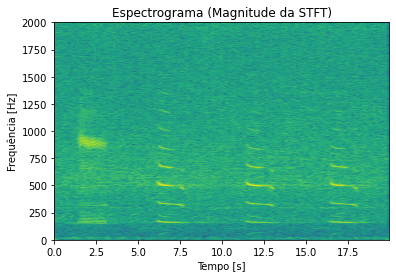

In [4]:
# Exemplo 4: Espectrograma do canto da baleia azul,
# visto com a FFT em aulas passadas
import os
import IPython.display as ipd
import librosa
import librosa.display

# carregando um arquivo
# lendo arquivo wav
file = os.path.join('.', 'data', 'bluewhale.au')
x,fs = librosa.load(file, sr=None)

# habilita o player do áudio
ipd.display(ipd.Audio(data=x, rate=fs))

# Ajuste e cômputo da STFT
nperseg = 1024
noverlap = nperseg//2 # divisao inteira
nfft = 2*nperseg
f, t, Zxx = signal.stft(x, fs, nperseg=nperseg,
                        noverlap=noverlap, nfft=nfft)
plt.pcolormesh(t, f, 20*np.log10(np.abs(Zxx)), shading='gouraud')
plt.title('Espectrograma (Magnitude da STFT)')
plt.ylabel('Frequência [Hz]')
plt.xlabel('Tempo [s]')
plt.show()